### TVLA using min-$p$ as a performance measure.

In [1]:
import numpy as np
from numpy.testing import assert_equal, assert_almost_equal
from scipy.stats import t as stats_t
from scipy.stats import ttest_ind

In [2]:
from tqdm import tqdm
from src.tools.plotter import plot_p_gradient, plot_accu
from src.tvla.accu import TvlaAccu


def make_t_test(n: int):
    """
    Returns a t-test that takes the sample mean and variance for a list of sample points from A, and a list of sample
    points for B.
    """
    n_sqrt = np.sqrt(n)
    nmm = n - 1

    def welch_t_test(a: np.array, b: np.array):
        mean_a, var_a = a
        mean_b, var_b = b

        # Prevent division by 0 errors
        var_a += .001
        var_b += .001

        m = mean_a - mean_b
        s = np.sqrt(var_a + var_b) / n_sqrt

        t = m / s

        dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)

        p = 2 * stats_t(df=dof).cdf(-np.abs(t))

        return t, p

    return welch_t_test

In [3]:
TRACE_LEN = 1400

def gen_example(mean, trace_num, trace_len=TRACE_LEN):
    return np.random.normal(mean, 2.2, size=(trace_num, trace_len)).astype(np.uint8)

def gen_random(mean_a, mean_b, trace_num, trace_len=TRACE_LEN):
    ex_random = np.array([gen_example(mu, trace_num) for mu in [mean_a, mean_b]]).reshape(2 * trace_num, trace_len)
    np.random.shuffle(ex_random)

    return ex_random[NUM_TRACES:], ex_random[:NUM_TRACES]

def get_mv(x: np.array):
    return np.array((x.mean(axis=0), x.var(axis=0)))

NUM_TRACES = 1000

ex_a1 = gen_example(80, NUM_TRACES)
ex_a2 = gen_example(80, NUM_TRACES)
ex_b1 = gen_example(81, NUM_TRACES)
ex_r1, ex_r2 = gen_random(80, 81, NUM_TRACES)

In [4]:
res_sp = ttest_ind(ex_a1, ex_b1, axis=0, equal_var=False)[1]

res_sp[:5]

array([4.83039635e-21, 1.29351375e-19, 2.44259098e-28, 9.04457205e-24,
       1.25040458e-20])

In [5]:
test = make_t_test(NUM_TRACES)

res_custom = test(get_mv(ex_a1), get_mv(ex_b1))[1]

res_custom[:5]

array([4.66688893e-21, 1.25212828e-19, 2.32889031e-28, 8.69447478e-24,
       1.20825643e-20])

In [6]:
ex_test_aa = np.min(test(get_mv(ex_a1), get_mv(ex_a2))[1])
ex_test_ab = np.min(test(get_mv(ex_a1), get_mv(ex_b1))[1])

ex_test_aa, ex_test_ab

(0.0010600531919137794, 3.301687067893557e-41)

$\sigma^2=\frac{1}{N}\underset{i=1}{\overset{N}{\sum}}{x_i^2-\mu^2} =
\underset{i=1}{\overset{N}{\sum}}{(\frac{x_i^2}{N}-\frac{\mu^2}{N})}$

In [7]:
class Accu:
    def __init__(self, trace_len: int):
        self.n = 0
        self.mean = np.zeros(trace_len, dtype=np.float128)
        self.var = np.zeros(trace_len, dtype=np.float128)
        self.cm = np.zeros(trace_len, dtype=np.float128)

    def add(self, trace):
        self.n += 1

        if self.n > 1:
            self.mean += (-self.mean + trace) / self.n
        else:
            self.mean = trace

        self.cm += (-self.cm + np.power(trace, 2)) / self.n
        self.var = self.cm - np.power(self.mean, 2)

    def get_mean(self):
        return self.mean.astype(np.float64)

    def get_var(self):
        return self.var.astype(np.float64)


# acc = Accu(ex_a.shape[1])
# [acc.add(ex_a[i]) for i in range(len(ex_a))]
#
# acc.get_var(), ex_a.var(axis=0)

In [8]:
ns = np.repeat(1 / np.arange(1, len(ex_a1) + 1)[:, np.newaxis], ex_a1.shape[1], axis=1)
cs_mean = np.cumsum(ex_a1, axis=0) * ns

cs_mean[-1][:5], ex_a1.mean(axis=0)[:5]

(array([79.537, 79.507, 79.462, 79.471, 79.442]),
 array([79.537, 79.507, 79.462, 79.471, 79.442]))

In [9]:
x2 = np.cumsum(np.power(ex_a1, 2) - np.power(cs_mean, 2), axis=0) * ns
x2[-1][:5], ex_a1.var(axis=0)[:5]

(array([-6229.39907474, -6193.91670736, -6212.87660533, -6220.76313712,
        -6180.26245674]),
 array([4.646631, 5.133951, 5.148556, 4.641159, 4.708636]))

In [10]:
def mv_cumsum(a):
    a = a.astype(np.float128)
    n = np.repeat(np.arange(1, len(a) + 1)[:, np.newaxis], a.shape[1], axis=1).astype(np.float128)

    a_mean = np.cumsum(a, axis=0) / n
    a_var = np.cumsum(np.power(a, 2), axis=0) / n - np.power(a_mean, 2)

    return np.array([a_mean.astype(np.float64), a_var.astype(np.float64)])

def p_gradient(a, b):
    trace_len = a.shape[1]
    assert trace_len == b.shape[1]

    max_traces = max(len(a), len(b))
    mv_a, mv_b = mv_cumsum(a), mv_cumsum(b)

    res = np.ones(max_traces)
    min_res = 1
    for i in tqdm(range(1, max_traces)):
        t_test = make_t_test(i+1)
        min_res = min(min_res, np.min(t_test(mv_a[:, i], mv_b[:, i])[1]))

        res[i] = min_res

    return res

mv_cumsum(ex_a1)[1][-1], ex_a1.var(axis=0)

(array([4.646631, 5.133951, 5.148556, ..., 4.703984, 5.059559, 4.992839]),
 array([4.646631, 5.133951, 5.148556, ..., 4.703984, 5.059559, 4.992839]))

100%|██████████| 999/999 [00:00<00:00, 1196.60it/s]


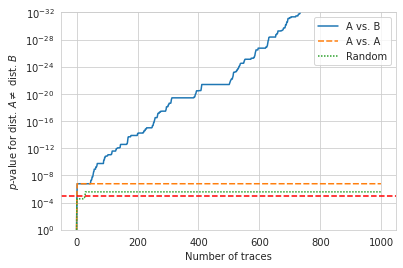

In [11]:
plot_p_gradient({
    "A vs. B": p_gradient(ex_a1, ex_b1),
    "A vs. A": p_gradient(ex_a1, ex_a2),
    "Random": p_gradient(ex_r1, ex_r2),
})

100%|██████████| 999/999 [00:00<00:00, 1148.68it/s]


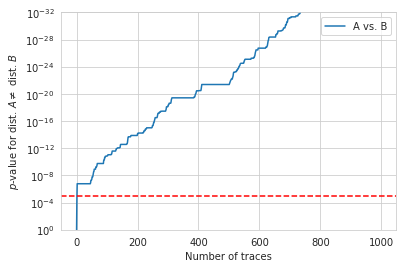

In [12]:
plot_p_gradient({
    "A vs. B": p_gradient(ex_a1, ex_b1),
})

In [23]:
acc = TvlaAccu(ex_a1.shape[1])
acc.add(ex_a1, ex_b1)

assert_equal(acc.last[0][0], ex_a1.mean(axis=0))
assert_equal(acc.last[1][0], ex_b1.mean(axis=0))
assert_almost_equal(acc.last[0][1], ex_a1.var(axis=0))
assert_almost_equal(acc.last[1][1], ex_b1.var(axis=0))

Running t-tests: 100%|██████████| 999/999 [00:00<00:00, 1083.51it/s]


In [ ]:
Z = zip(acc.p_gradient, [min(ttest_ind(ex_a1[:t], ex_b1[:t])[1]) for t in tqdm(range(2, len(ex_a1)))])

In [ ]:
list(Z)

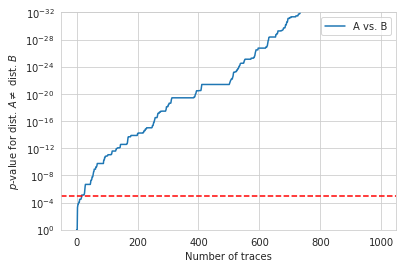

In [16]:
plot_accu({"A vs. B": acc})